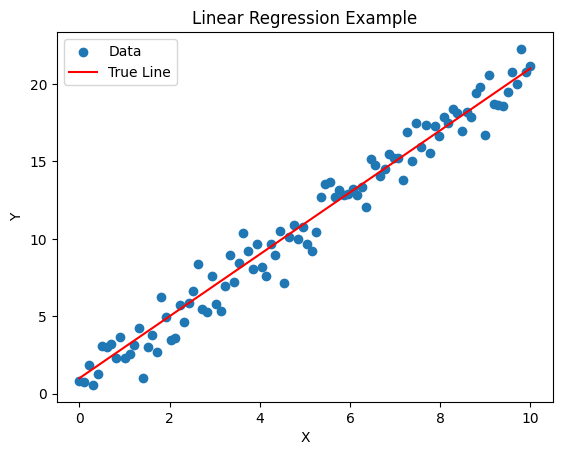

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

x = np.linspace(0, 10, 100)
y = 2 * x + 1 + np.random.normal(0, 1, size=x.shape)
plt.scatter(x, y, label='Data')
plt.plot(x, 2 * x + 1, color='red', label='True Line')
plt.xlabel('X')
plt.ylabel('Y')
plt.title('Linear Regression Example')
plt.legend()
plt.show()